In [807]:
import requests
import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import time
import spacy
import wikipedia
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
#displacy.serve(doc, style='ent')
import warnings
warnings.filterwarnings("ignore")

In [808]:
conn_string = 'postgres://' + username + ':' + password + '@' + hostname + '/' + database
db = create_engine(conn_string)
conn = db.connect()

In [809]:

AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_I
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}


# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

In [586]:
names = ['Baila Reggeaton', 'El Ritmo', 'Puro Perreo', 'Mansion Reggeaton', 'Urbano Rising',
         'Perreo City', 'Fuego', 'Reggeaton Classics', 'Perrear y Llorar', 'Reggeaton Rewind',
         'Reggeaton Viejito', 'Suave', 'Academia Reggeaton', 'PEGAO', 'miticas', 'Reggeaton Chileno',
         'Reggeaton Argentino'
        ]
links = ['37i9dQZF1DWY7IeIP1cdjF', '37i9dQZF1DWVOLXBOylBUZ', 
         '37i9dQZF1DWX5ZOsG2Ogi1', '37i9dQZF1DWZjqjZMudx9T',
         '37i9dQZF1DX4OjfOteYnH8', '37i9dQZF1DWUlCmB8llCTB',
         '37i9dQZF1DX8sljIJzI0oo', '37i9dQZF1DX8SfyqmSFDwe',
         '37i9dQZF1DWXYWuNDAdJsw', '37i9dQZF1DXco4ODkIraMD',
         '37i9dQZF1DWWU6Rfto8Ppm', '37i9dQZF1DWSjuSq42neMu',
         '37i9dQZF1DXd8p9XRfIfUn', '37i9dQZF1DX1HCSfq0nSal',
         '37i9dQZF1DX2EiUAL7Wdfc', '37i9dQZF1DX5hIsIIk6w1F',
         '37i9dQZF1DX5hIsIIk6w1F'
        ]
ids = list(range(1, 18))

playlists_reggeaton = pd.DataFrame(
    {
        'id_playlist': ids,
        'playlists': names,
        'links': links
    }
)

In [798]:
# GET jsons of playlists
def playlists_jsons(playlist_id):

    time.sleep(20)
    r = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks', 
                     headers=headers, 
                     params={'include_groups':'track'})
    d = r.json()
    
    return d

def flatten(t):
    return [item for sublist in t for item in sublist]

def get_playlist_artists_id(playlists_reggeaton):

    artists_playlist = []
    for i, content in enumerate(playlists_reggeaton['items']):
        artists_song = []
        for idx, json in enumerate(playlists_reggeaton['items'][i]['track']['artists']):
            artists_song.append(json['id'])
        artists_playlist.append(artists_song)
        
    artists_playlist = flatten(artists_playlist)
    artists_playlist = list(set(artists_playlist))
    
    return artists_playlist

def get_playlist_songs_id(playlists_reggeaton):
    
    #time.sleep(1)

    song_id_playlist = []
    for i, content in enumerate(playlists_reggeaton['items']):
        song_id_playlist.append(content['track']['id'])
    
    return song_id_playlist

def get_artist_name(artist_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'artists/' + artist_id, 
                     headers=headers, 
                     params={'include_groups':'track'})
    d = r.json()
    
    return d['name']


def get_track_name(track_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'tracks/' + track_id, headers=headers)
    d = r.json()
    
    return d['name']

def get_audio_features(track_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)
    track_features = r.json()
    
    return track_features

def get_audio_analysis(track_id):
    
    time.sleep(1)
    
    r = requests.get(BASE_URL + 'audio-analysis/' + track_id, headers=headers)
    audio_analysis = r.json()
    
    return audio_analysis


def build_table_features(playlist, label):
    
    list_tracks = []
    for i in playlist['items']:
        #print()
        dict_track = {}
        #print(i['track']['id'], i['track']['name'])
        
        try:

            dict_track['id_track'] = i['track']['id']
            dict_track['name_track'] = i['track']['name']
            dict_track['features_track'] = get_audio_features(i['track']['id'])


            dict_artists = {}
            for idx, content in enumerate(i['track']['artists']):
                #print(content['id'], content['name'])
                dict_artists['id_artist' + '_' + str(idx)] = content['id']
                dict_artists['name_artist' + '_' + str(idx)] = content['name']

            dict_artists_track = dict((key, value) for d in (dict_artists, dict_track) for key, value in d.items())
            list_tracks.append(dict_artists_track)
        
        except:
            pass
            
        try:
            df = pd.json_normalize(list_tracks)

            if label == 0 or label == 1:
                df['target'] = label
            else:
                pass
        except:
            pass

    return df

def get_wikipedia_page(artist):
    
    time.sleep(1)
    artist = artist.lower()
    print(artist)
    try:
        result = wikipedia.search(artist)
        page = wikipedia.page(result[0], auto_suggest=False)
    except:
        try:
            artist = artist + ' (singer)'
            result = wikipedia.search(artist)
            page = wikipedia.page(result[0], auto_suggest=False)
        except:
            text_page = 'None'
            return text_page
        
    text_page = page.content
    text_page = text_page.split('\n\n\n')[0]
    
    return text_page

def get_NER_wikipedia(text_page):
    
    doc = nlp(text_page)
    liste = []
    if doc.ents:
        for token in doc.ents:
            if (token.label_ == 'GPE' and get_continent(token.text) != ('Unknown', 'Unknown')) or token.label_ == 'NORP':
                #print(token.text, token.label_)
                liste.append(token.text)
    return liste

def get_country_nationality(potential_country, nationality_bdd):
    
    try:
        country = nationality_bdd['Country'][nationality_bdd['Nationality'] == potential_country].values[0]
    except:
        country = 'None'

    return country


def send_country_name(liste):
    
    for idx, potential_country in enumerate(liste):
        if get_country_nationality(potential_country, nationality_bdd) != 'None' or get_continent(potential_country) != ('Unknown', 'Unknown'):

            if get_country_nationality(potential_country, nationality_bdd) != 'None':
                name = get_country_nationality(potential_country, nationality_bdd)
            elif get_continent(potential_country) != ('Unknown', 'Unknown'):
                name = get_continent(potential_country)

            #print("Country : ", name)
            return name
            break
            
def get_continent(col):
    
    if type(col) == tuple:
        return (col)
    
    else:
        try:
            cn_a2_code =  country_name_to_country_alpha2(col)
        except:
            cn_a2_code = 'Unknown' 
        try:
            cn_continent = country_alpha2_to_continent_code(cn_a2_code)
        except:
            cn_continent = 'Unknown' 
        return (cn_a2_code, cn_continent)


#function to get longitude and latitude data 
from geopy.geocoders import Nominatim
geolocator = Nominatim()

def geolocate(country):
    
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

def get_countryname_with_code(name_country):
    if type(name_country) == tuple:
        
        coude_tuple = name_country
        name_country = pycountry.countries.get(alpha_2=coude_tuple[0])
        name_country = name_country.name 
        return name_country
    else:
        return name_country

In [6]:
playlists_reggeaton['json'] = playlists_reggeaton['links'].apply(lambda x: playlists_jsons(x))
playlists_reggeaton['artists'] = playlists_reggeaton['json'].apply(lambda x: get_playlist_artists_id(x))
playlists_reggeaton['songs'] = playlists_reggeaton['json'].apply(lambda x: get_playlist_songs_id(x))

In [7]:
playlists_reggeaton.to_sql('playlists', con=conn, 
                           if_exists='replace', index=False,
                           dtype={"id_playlist":sqlalchemy.types.Integer(),
                                  "playlists":sqlalchemy.types.STRINGTYPE,
                                  "links":sqlalchemy.types.STRINGTYPE,
                                  "json":sqlalchemy.types.JSON,
                                  "artists":sqlalchemy.types.JSON,
                                  "songs":sqlalchemy.types.JSON,
                                 
                                 })

In [8]:
conn = psycopg2.connect(conn_string)
try:
    SQL_Query = pd.read_sql_query(
        '''SELECT * FROM playlists;''', conn)

    df = pd.DataFrame(SQL_Query, columns=['id_playlist', 'playlists', 'links', 'json', 'artists', 'songs'])
    print('The data type of df is: ', type(df))
except:
    print("Error: unable to convert the data")

#conn.close()

The data type of df is:  <class 'pandas.core.frame.DataFrame'>


# Modèle recommandation

In [733]:
names = ['Buen Reggeaton', 'Mal Reggeaton', 'Salsa Cubana', 'Variete francaise', 'Cuecas Chilenas',
         'Musica Peruana', 'Black Lives Matter', 'Incontournables', 'Indispensables francais',
         'Piano Tranquile', 'Ludovico Einaudi', 'Atmospheric Piano', 'Reggeaton Hits',
         'Pop Urbaine', 'Valide', 'Fresh Rap', 'PUNCHLINERS', 'Best off US Rap', 'Classique Rap',
         'Rap US 2000', 'Rap US 2000 Vol.2', 'Gaming Rap US', 'Rap 2022', 'Guaracha 2022',
         'Hit Radio', 'Apero !', 'Alors on danse', 'Flashback', 'Disco', "a l'ancienne",
         'Alternative R&B', 'Funk outta here', '80s jam session', 'Metal Essentials',
         'Hellfet 2022', 'Heavy Metal', 'Global Groove', 'Flashback', 'Bossa Nova', 'Samba de Raiz',
         'Tropicalia', 'This is Frequency', 'Riple Effect', 'House Party', 'Heard You', 'One Love',
         'Israeli party', 'Kpop'
         ]

links = ['7bq37waj4hFMTZ6XEy4Db0', '330g098HZqqxUByG3FICzB',
         '37i9dQZF1DWVSSKiqqNKSC', '37i9dQZF1DXcSPhLAnCjoM',
         '7IVfZGK963zl7NvxUv1OPr', '6e5jDnWhQg72y3Aynq744b',
         '37i9dQZF1DWWAqc46ZJdZf', '37i9dQZF1DWYX0SFpLcPgx',
         '37i9dQZF1DX61tcJXPSFg7', '37i9dQZF1DX4FLflF8wPKE',
         '37i9dQZF1DWUofLlXqRWZz', '37i9dQZF1DWURCUKHUKWCX',
         '3fm4Brxt2u29y6Jm32wLJY', '37i9dQZF1DWYVURwQHUqnN',
         '37i9dQZF1DX4WpYT2fah9c', '37i9dQZF1DWU4xkXueiKGW',
         '37i9dQZF1DX1X23oiQRTB5', '5lNCNfSOwUlfxTED32G8Ff',
         '3sU60rLrcVv1g2LHeBY3AH', '2olAGUcxrrOCA42SmlxOaS',
         '7jaKOwABaOUPrv7NbTVsLM', '5QsPhQg0m1Q5LztA5dU2u7',
         '7qcdXKyfXkk7cBSQ2Fmwvn', '7LDpUAjCFTJVKPikrKVSJy',
         '37i9dQZF1DXbS5WTN5nKF7', '37i9dQZF1DWZk2SPZ3bugX',
         '37i9dQZF1DWUwJ0RFwrgQP', '37i9dQZF1DWXncK9DGeLh7',
         '37i9dQZF1DWTZQgENtHuxI', '37i9dQZF1DX9UuQbl12Nmb',
         '37i9dQZF1DWSfMe9z89s9B', '37i9dQZF1DX70TzPK5buVf',
         '37i9dQZF1DX0H8hDpv38Ju', '37i9dQZF1DWWOaP4H0w5b0',
         '37i9dQZF1DWZnlcbl9Edex', '37i9dQZF1DX9qNs32fujYe',
         '37i9dQZF1DWUS3jbm4YExP', '37i9dQZF1DWXncK9DGeLh7',
         '37i9dQZF1DX4AyFl3yqHeK', '37i9dQZF1DWTUHOvJwQIMp',
         '37i9dQZF1DXbEVW4FA74zM', '37i9dQZF1DWVgsJtp58d1t',
         '37i9dQZF1DX5qjSia2PLFP', '37i9dQZF1DXaaLM83puGG5',
         '37i9dQZF1DWVu3lAQuOIjU', '37i9dQZF1DWSiyIBdVQrkk',
         '20jHkvLZrSIOjuQBVurEms', '37i9dQZF1DX9tPFwDMOaN1'
         
         ]
ids = list(range(1, 49))

playlists_reggeaton = pd.DataFrame(
    {
        'id_playlist': ids,
        'playlists': names,
        'links': links
    }
)

In [734]:
playlists_reggeaton['json'] = playlists_reggeaton['links'].apply(lambda x: playlists_jsons(x))

In [762]:
playlists_reggeaton

,id_playlist,playlists,links,json
0,1,Buen Reggeaton,7bq37waj4hFMTZ6XEy4Db0,{'href': 'https://api.spotify.com/v1/playlists...
1,2,Mal Reggeaton,330g098HZqqxUByG3FICzB,{'href': 'https://api.spotify.com/v1/playlists...
2,3,Salsa Cubana,37i9dQZF1DWVSSKiqqNKSC,{'href': 'https://api.spotify.com/v1/playlists...
3,4,Variete francaise,37i9dQZF1DXcSPhLAnCjoM,{'href': 'https://api.spotify.com/v1/playlists...
4,5,Cuecas Chilenas,7IVfZGK963zl7NvxUv1OPr,{'href': 'https://api.spotify.com/v1/playlists...
5,6,Musica Peruana,6e5jDnWhQg72y3Aynq744b,{'href': 'https://api.spotify.com/v1/playlists...
6,7,Black Lives Matter,37i9dQZF1DWWAqc46ZJdZf,{'href': 'https://api.spotify.com/v1/playlists...
7,8,Incontournables,37i9dQZF1DWYX0SFpLcPgx,{'href': 'https://api.spotify.com/v1/playlists...
8,9,Indispensables francais,37i9dQZF1DX61tcJXPSFg7,{'href': 'https://api.spotify.com/v1/playlists...
9,10,Piano Tranquile,37i9dQZF1DX4FLflF8wPKE,{'href': 'https://api.spotify.com/v1/playlists...


In [763]:
playlists_reggeaton = playlists_reggeaton[playlists_reggeaton['json'] != {'error': {'status': 404, 'message': 'Not found.'}}]

In [772]:
dfs = np.split(playlists_reggeaton, [round(playlists_reggeaton.shape[0] / 2)], axis=0)

In [773]:
good = dfs[0]
bad = dfs[1]

In [774]:
good_jsons = list(good['json'])
bad_jsons = list(bad['json'])

In [779]:
list_datasets = []
for i in good_jsons:
    df = build_table_features(playlist=i, label=1)
    list_datasets.append(df)
good_ = pd.concat(list_datasets)
good_ = good_.reset_index(drop=True)

In [800]:
list_datasets = []
for i in bad_jsons:
    df = build_table_features(playlist=i, label=0)
    list_datasets.append(df)
bad_ = pd.concat(list_datasets)
bad_ = bad_.reset_index(drop=True)

In [805]:
good_.to_csv('good_.csv')
bad_.to_csv('bad_.csv')

In [802]:
data = pd.concat([good_, bad_])
data = data.fillna('None')
data = data.sample(frac=1).reset_index(drop=True)

In [803]:
print(data.shape)
data.head()

(2873, 73)


,id_artist_0,name_artist_0,id_artist_1,name_artist_1,id_track,name_track,features_track.danceability,features_track.energy,features_track.key,features_track.loudness,...,id_artist_20,name_artist_20,id_artist_21,name_artist_21,id_artist_22,name_artist_22,id_artist_23,name_artist_23,id_artist_24,name_artist_24
0,3IJ21966TwNZI24MwZHMu4,Baby Tate,None,None,65HXJWOYBX2pFpdtusWRiV,Dancing Queen,0.908,0.559,11.0,-6.329,...,None,None,None,None,None,None,None,None,None,None
1,4DDlcMniR5obaLi3lcy8uI,Grupo Maravilla,None,None,5KWhCMSUX1pdcngvVtAD0U,Antahuara,0.713,0.685,6.0,-5.313,...,None,None,None,None,None,None,None,None,None,None
2,5Y8g8xQA1pNHnnfFznkcqZ,Victor Solf,1s9CZWvJiTtwfhs1WevDDA,Zefire,3rPWP9FwCB2vRDJcjGnx0a,How Did We?,0.911,0.501,8.0,-9.056,...,None,None,None,None,None,None,None,None,None,None
3,4O6RDLeFX5xuQ7IePFzVcl,Demons & Wizards,None,None,3QmT40QBlxr4n5AxhOSxkf,Diabolic,0.283,0.944,11.0,-7.202,...,None,None,None,None,None,None,None,None,None,None
4,6urzdpGY5yUimWZsgJUoTb,Airbourne,None,None,1wXuogT7bvqnhuWzDBNOdV,Runnin' Wild,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [810]:
data['origin_artist'] = data['name_artist_0'].apply(lambda x: send_country_name(get_NER_wikipedia(get_wikipedia_page(x))))

baby tate
grupo maravilla
victor solf
demons & wizards
airbourne
bolémvn
the stance brothers
mariah the scientist
lykke li
owlle
kalash
nicky jam
cris mj
lionaire
the naked and famous
sarah watson
santigold
jef martens
edvard kravchuk
masked wolf
geraldine hunt
anthony b
nicky jam
lucas pazos
richard luke
nija
los gatos blancos
beth carvalho
robert de visée
daddy yankee
léa castel
masego
edvard kravchuk
maluma
akira kosemura
the brothers johnson
maihuen de los angeles
glass beams
kelow latesha
nuttea
valentin silvestrov
riton
eliad
gloria gaynor
omar apollo
martinho da vila
kwon eun bi
l'impératrice
ripple
beth carvalho
maihuen de los angeles
ed sheeran
gims
massianello
caracol televisión
trío añoranzas
amara ignacia
thelma houston
beth ditto
dj reys
charlotte adigéry
stretch
amon amarth
leto
dijahsb
kendrick lamar
jex nwalor
regard
four tops
cnco
the o'jays
ed sheeran
jay 305
charlotte cardin
sleepy hallow
jackson love
osvaldo montero
the notorious b.i.g.
juaneco y su combo
clara nune

In [811]:
data['origin_artist'] = data['origin_artist'].apply(lambda x: get_countryname_with_code(x))

In [812]:
data.to_sql('use_case', con=conn, if_exists='replace', index=False, chunksize=20)

In [815]:
data = data[data['features_track.danceability'] != 'None']

# Map

In [816]:
# Import pandas library
import pandas as pd
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import folium
from folium.plugins import MarkerCluster

In [ ]:
nationality_bdd = pd.read_csv('demonyms.csv')
nationality_bdd.columns = ['Nationality', 'Country']
#nationality_bdd.to_sql('nationality', con=conn, if_exists='replace', index=False, chunksize=20)

In [817]:
countries = pd.DataFrame(data.origin_artist.value_counts(normalize=True))
countries = countries.reset_index()
countries.columns = ['CountryName', 'Artists_Percent']

In [818]:
countries['codes'] = countries['CountryName'].apply(lambda x: get_continent(x))
countries['CountryName'] = countries['CountryName'].apply(lambda x: get_countryname_with_code(x))
countries[['Country', 'Continent']] = pd.DataFrame(countries['codes'].tolist(), index=countries.index)
countries['Geolocate'] = countries['CountryName'].apply(lambda x: geolocate(x))
countries[['Latitude', 'Longitude']] = pd.DataFrame(countries['Geolocate'].tolist(), index=countries.index)

In [821]:
countries = countries[countries['Country'] != 'Unknown']
countries = countries.dropna()

In [822]:
world_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)#for each coordinate, create circlemarker of user percent
for i in range(len(countries)):
        lat = countries.iloc[i]['Latitude']
        long = countries.iloc[i]['Longitude']
        radius = 5
        popup_text = """Country : {}<br>
                    %of artists : {}<br>"""
        popup_text = popup_text.format(countries.iloc[i]['Country'],
                                   countries.iloc[i]['Artists_Percent']
                                   )
        folium.CircleMarker(location = [lat, long], 
                            radius=radius, popup=popup_text, 
                            fill=True).add_to(marker_cluster)#show the map
world_map

### END map

In [664]:
artists = data[data.columns[pd.Series(data.columns).str.startswith('name_artist')]]
artists = artists[['name_artist_0', 'name_artist_1']]
artists = artists[artists['name_artist_1'] != 'None']
#artists = artists.head(100)

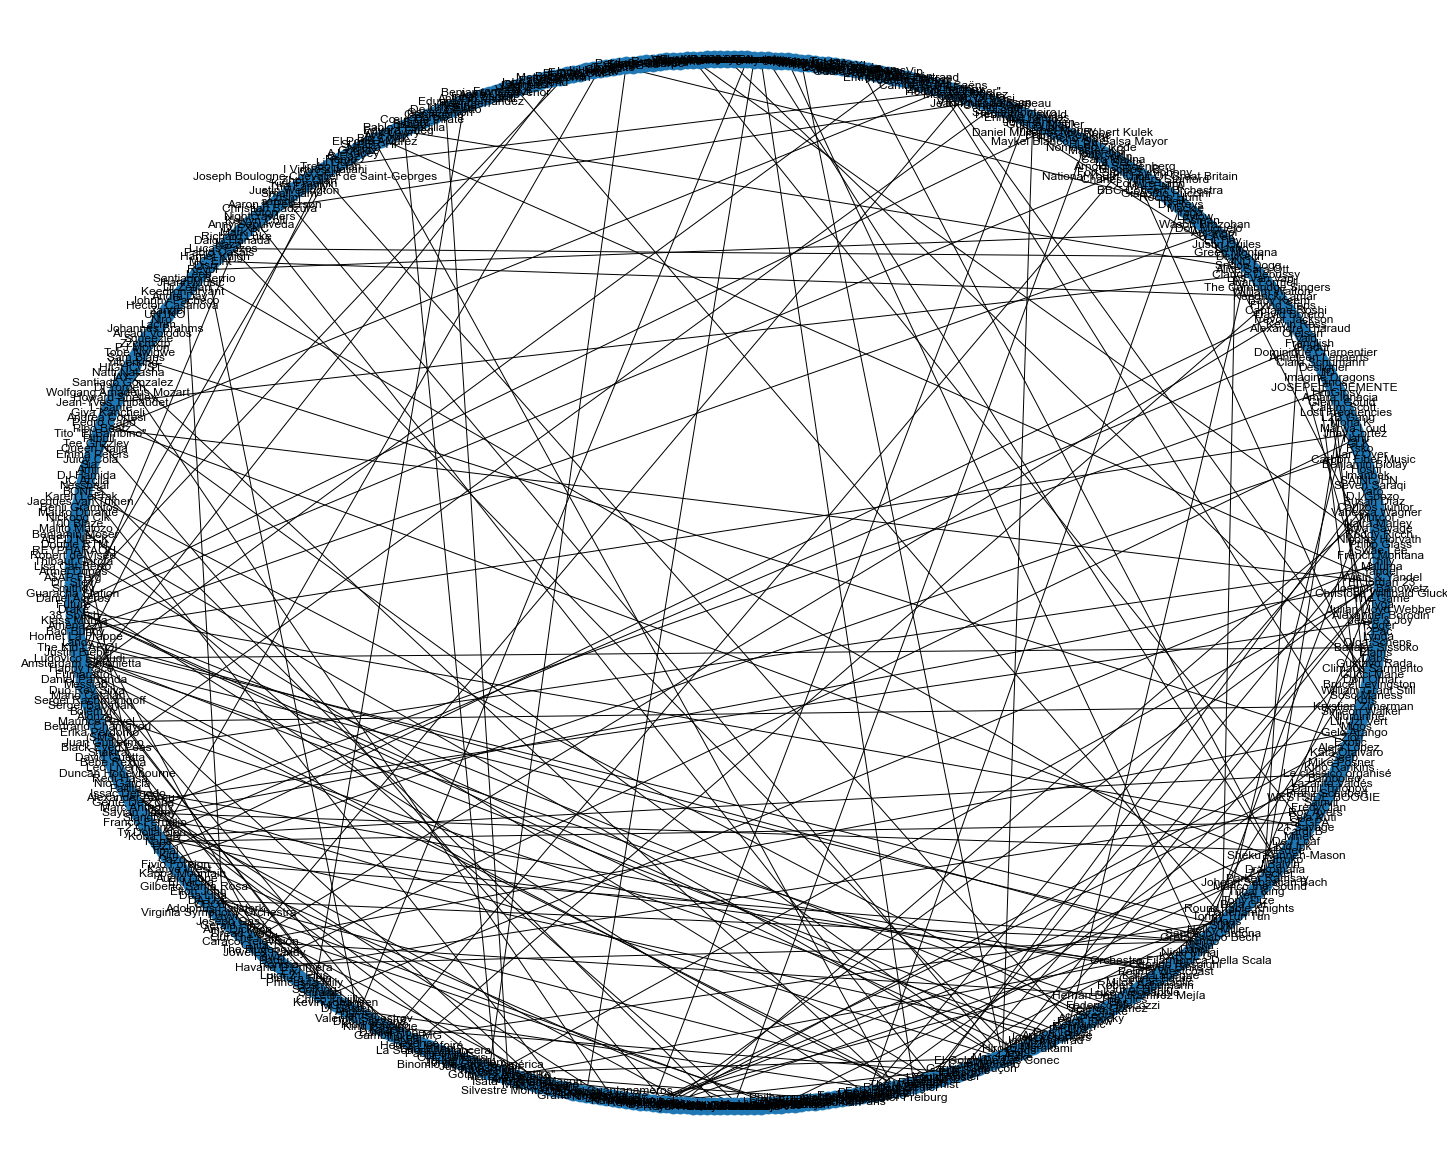

In [665]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(artists, 'name_artist_0', 'name_artist_1')

from matplotlib.pyplot import figure
figure(figsize=(20, 16))
nx.draw_shell(G, with_labels=True)

# Recommandation model

In [666]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 20)
import matplotlib
matplotlib.get_backend()
%matplotlib inline
plt.style.use('seaborn')
import re
import scikitplot as skplt

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [667]:
def score_cross_val(scores):
    
    # Scores sur cross validation
    scores = pd.DataFrame(scores)
    scores.plot()

    plt.xlabel('CV')
    plt.ylabel('Score')
    plt.title("Scores sur le train de chaque cross validation")

    plt.axis()
    plt.legend("scores", loc='upper center')
    plt.show()

def plot_roc_auc_curve(model, X_test, y_test):
    
    # overall accuracy
    acc = model.score(X_test, y_test)

    # get roc/auc info
    # predict_proba is the porbability that X takes a class
    Y_score = model.predict_proba(X_test)[:, 1] 
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, Y_score)

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.title('ROC curve and AUC')
    plt.show()


def plot_corr_matrix(df):
    
    data_correlation = df[list(df.columns)].corr()
    mask = np.array(data_correlation)
    mask[np.tril_indices_from(mask)] = False
    fig = plt.subplots(figsize=(30,20))
    sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True);


In [668]:
data.head()

,id_artist_0,name_artist_0,id_artist_1,name_artist_1,id_track,name_track,features_track.danceability,features_track.energy,features_track.key,features_track.loudness,...,name_artist_10,id_artist_11,name_artist_11,id_artist_12,name_artist_12,id_artist_13,name_artist_13,features_track.error.status,features_track.error.message,origin_artist
0,4vkOLg1AyJgDqF9xwLsgXR,Maihuen de los Angeles,None,None,40ZlhDTAVeV88Jct6ytpYG,Se Fue Tu Amor,0.648,0.606,9.0,-6.906,...,None,None,None,None,None,None,None,None,None,None
1,4MCBfE4596Uoi2O4DtmEMz,Juice WRLD,None,None,2U5WueTLIK5WJLD7mvDODv,Wishing Well,0.65,0.613,9.0,-6.13,...,None,None,None,None,None,None,None,None,None,United States
2,52wcA7uQEIW0jVqgd6DvUf,Dr. Stev,0S8aCoNNlL7Jm9AALivJD7,Smithdy,23mDSgv45YRmmBMaVOtUxV,Tranquila Mi Amor,0.696,0.852,9.0,-7.7,...,None,None,None,None,None,None,None,None,None,France
3,0iqgjl0OG3z53PZVIB7ZyD,Víkingur Ólafsson,None,None,3mrWC8aEj9JrxKl6gQ0HRv,Reflection,0.426,0.0153,1.0,-32.834,...,None,None,None,None,None,None,None,None,None,Iceland
4,47ozU8ojeYteeyLXo5dLrZ,Guaracha Station,6gwJmMEElfAzBtcXUITk64,Daniel Aceros,0f4mNMkg5qgET6RKcDiBoP,Sentidos,0.704,0.741,3.0,-7.239,...,None,None,None,None,None,None,None,None,None,Puerto Rico


In [669]:
data.columns

Index(['id_artist_0', 'name_artist_0', 'id_artist_1', 'name_artist_1',
       'id_track', 'name_track', 'features_track.danceability',
       'features_track.energy', 'features_track.key',
       'features_track.loudness', 'features_track.mode',
       'features_track.speechiness', 'features_track.acousticness',
       'features_track.instrumentalness', 'features_track.liveness',
       'features_track.valence', 'features_track.tempo', 'features_track.type',
       'features_track.id', 'features_track.uri', 'features_track.track_href',
       'features_track.analysis_url', 'features_track.duration_ms',
       'features_track.time_signature', 'id_artist_2', 'name_artist_2',
       'id_artist_3', 'name_artist_3', 'id_artist_4', 'name_artist_4',
       'target', 'id_artist_5', 'name_artist_5', 'id_artist_6',
       'name_artist_6', 'id_artist_7', 'name_artist_7', 'id_artist_8',
       'name_artist_8', 'id_artist_9', 'name_artist_9', 'id_artist_10',
       'name_artist_10', 'id_artist_11',

In [670]:
df_reco = data[['name_artist_0', 'features_track.danceability', 'features_track.energy',
       'features_track.key', 'features_track.loudness', 'features_track.mode',
       'features_track.speechiness', 'features_track.acousticness',
       'features_track.instrumentalness', 'features_track.liveness',
       'features_track.valence', 'features_track.tempo', 'features_track.duration_ms',
       'features_track.time_signature', 'origin_artist', 'target']]

In [678]:
df_reco
df_reco = df_reco[df_reco['features_track.danceability'] != 'None']

In [679]:
ord_enc = OrdinalEncoder()
df_reco["name_artist_0"] = ord_enc.fit_transform(df_reco[["name_artist_0"]])
df_reco["origin_artist"] = ord_enc.fit_transform(df_reco[["origin_artist"]])

In [695]:
df_reco.head()

,name_artist_0,features_track.danceability,features_track.energy,features_track.key,features_track.loudness,features_track.mode,features_track.speechiness,features_track.acousticness,features_track.instrumentalness,features_track.liveness,features_track.valence,features_track.tempo,features_track.duration_ms,features_track.time_signature,origin_artist,target
0,348.0,0.648,0.6060,9.0,-6.906,1.0,0.0374,0.20800,0.000,0.1290,0.9390,119.145,130720.0,3.0,62.0,1
1,264.0,0.650,0.6130,9.0,-6.130,0.0,0.1280,0.00336,0.000,0.2670,0.0804,149.972,194621.0,4.0,61.0,0
2,136.0,0.696,0.8520,9.0,-7.700,0.0,0.0418,0.17500,0.313,0.0832,0.2900,124.983,281346.0,4.0,23.0,0
3,517.0,0.426,0.0153,1.0,-32.834,1.0,0.0372,0.99300,0.957,0.1080,0.2650,104.717,332747.0,4.0,30.0,0
4,206.0,0.704,0.7410,3.0,-7.239,0.0,0.0744,0.01860,0.156,0.1520,0.2950,128.038,181871.0,4.0,50.0,0


In [693]:
df_reco = df_reco.apply(pd.to_numeric)

In [694]:
df_reco.describe()

,name_artist_0,features_track.danceability,features_track.energy,features_track.key,features_track.loudness,features_track.mode,features_track.speechiness,features_track.acousticness,features_track.instrumentalness,features_track.liveness,features_track.valence,features_track.tempo,features_track.duration_ms,features_track.time_signature,origin_artist,target
count,887.000000,887.000000,887.00000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,272.864713,0.622108,0.51440,5.545660,-11.893117,0.526494,0.110192,0.431517,0.241789,0.157796,0.485625,115.957298,213405.927847,3.850056,42.198422,0.547914
std,146.069102,0.219234,0.28941,3.528008,9.784069,0.499579,0.103971,0.366297,0.389658,0.122445,0.285003,29.534707,69658.097509,0.528059,19.106600,0.497980
min,0.000000,0.061800,0.00122,0.000000,-44.526000,0.000000,0.026100,0.000051,0.000000,0.015400,0.029300,55.481000,41660.000000,1.000000,0.000000,0.000000
25%,139.500000,0.449000,0.31650,2.000000,-13.414500,0.000000,0.042600,0.106000,0.000000,0.089100,0.227000,94.020000,173888.500000,4.000000,23.000000,0.000000
50%,293.000000,0.690000,0.60600,6.000000,-7.379000,1.000000,0.057800,0.306000,0.000042,0.110000,0.518000,116.887000,201334.000000,4.000000,50.000000,1.000000
75%,378.500000,0.796500,0.73350,9.000000,-5.692000,1.000000,0.141000,0.848500,0.638000,0.172000,0.733000,133.890500,238123.500000,4.000000,61.000000,1.000000
max,543.000000,0.974000,0.98900,11.000000,-1.109000,1.000000,0.563000,0.996000,0.986000,0.902000,0.972000,214.017000,729627.000000,5.000000,62.000000,1.000000


In [696]:
df_reco.shape

(887, 16)

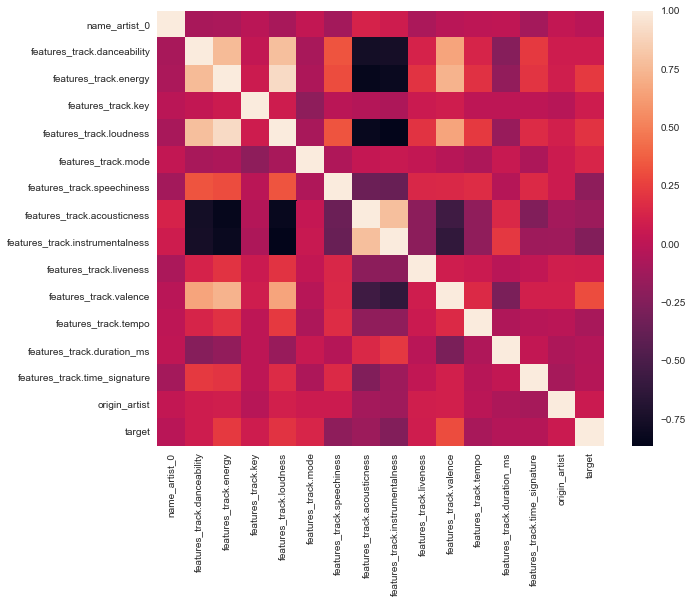

In [697]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df_reco.corr()
sns.heatmap(corr);

In [698]:
X = df_reco.loc[:, df_reco.columns != 'target']
y = df_reco['target']

In [699]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [700]:
xgb = XGBClassifier(max_depth=7,
                    learning_rate=0.1,
                    n_estimators=250)

xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=10)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_probas = xgb.predict_proba(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_xgb))
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(cf_matrix)

Accuracy: 0.775
[[58 19]
 [21 80]]


In [701]:
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

0.7752808988764045
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        77
           1       0.81      0.79      0.80       101

    accuracy                           0.78       178
   macro avg       0.77      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178



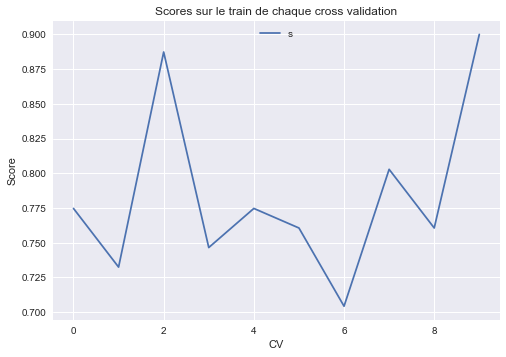

In [702]:
score_cross_val(scores)

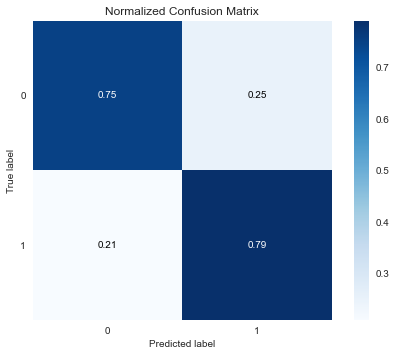

In [703]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb, normalize=True)
plt.show()

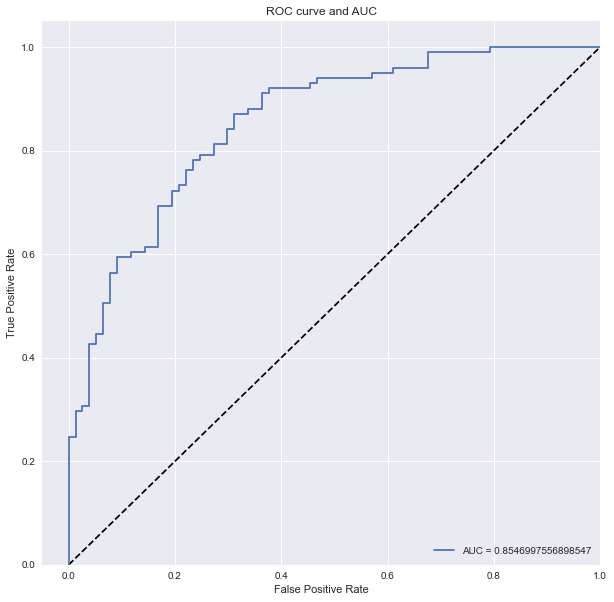

In [704]:
plot_roc_auc_curve(xgb, X_test, y_test)